# Introduction

### Purpose

This notebook is devoted to identifying the most effective algorithm for predicting diabetes onset within the Pima Indians Diabetes Database, comparing Logistic Regression, Decision Trees, Gradient Boosting (XGBoost), and Random Forest. My aim is to determine which model delivers the highest predictive performance on this dataset, achieving both accuracy and robust generalization through meticulous preprocessing, exploratory analysis, class balancing with a custom SMOTE implementation, and optimization strategies

### Dataset Descripton

The Pima Indians Diabetes Database contains 768 records of female patients of Pima Indian heritage, aged 21 and older. It includes eight clinical features: Pregnancies, Glucose, Blood Pressure, Skin Thickness, Insulin, BMI, Diabetes Pedigree Function, and Age. The binary "Outcome" variable (0 = no diabetes, 1 = diabetes) exhibits approximately 35% positive cases (268 instances). The dataset presents challenges such as missing values encoded as zeros and a moderate class imbalance, addressed in this study through preprocessing and synthetic oversampling.

# Setup

### Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from collections import Counter
import math
import shap
import xgboost as xgb
import logging
import shap
from tqdm import tqdm

### Configuration

Sets up logging, random seed, and defines functions for calculating classification metrics to Ensures consistent logging for debugging, reproducibility with a fixed seed, and provides tools to evaluate model performance quantitatively.

In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
np.random.seed(42)

def calculate_metrics(y_true, y_pred):
    """Calculate classification metrics."""
    accuracy = np.mean(y_pred == y_true)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1

def calculate_roc_auc(y_true, y_scores):
    """Calculate ROC curve and AUC, ensuring non-negative AUC."""
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true = y_true[sorted_indices]
    y_scores = y_scores[sorted_indices]
    tp, fp = 0, 0
    tpr_list, fpr_list = [0], [0]
    auc_score = 0.0
    pos, neg = np.sum(y_true == 1), np.sum(y_true == 0)
    for i in range(len(y_true)):
        if y_true[i] == 1:
            tp += 1
        else:
            fp += 1
        tpr = tp / pos if pos > 0 else 0
        fpr = fp / neg if neg > 0 else 0
        auc_score += (fpr - fpr_list[-1]) * (tpr + tpr_list[-1]) / 2
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return np.array(fpr_list), np.array(tpr_list), max(0, auc_score)

logger.info("Setup complete.")

# Data Loading

Prepares the raw data for analysis and gives a quick overview to understand its structure and characteristics.

In [ ]:
def load_data(file_path):

    try:
        data = pd.read_csv(file_path)
        logger.info(f"Dataset loaded: {data.shape[0]} rows, {data.shape[1]} columns")

        print("First 5 rows:")
        print(data.head())
        print("\nData types:")
        print(data.dtypes)
        print("\nBasic statistics:")
        print(data.describe())

        return data
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

file_path = '/content/drive/MyDrive/File Rocks/diabetes.csv'
data = load_data(file_path)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Data types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data splitting

Splits the dataset into training (70%), cross-validation (15%), and test (15%) sets with random shuffling to Create distinct subsets to train models, tune hyperparameters, and evaluate generalization on unseen data.

In [ ]:
def split_data(df, train_size=0.7, cv_size=0.15):
    """Split data into train, cross-validation, and test sets."""
    X = df.drop("Outcome", axis=1).values
    y = df["Outcome"].values
    if len(X) == 0 or len(y) == 0:
        raise ValueError("Input DataFrame is empty")
    indices = np.random.permutation(len(X))

    train_end = max(1, int(train_size * len(X)))
    cv_end = min(len(X), train_end + max(1, int(cv_size * len(X))))

    X_train = X[indices[:train_end]]
    X_cv = X[indices[train_end:cv_end]]
    X_test = X[indices[cv_end:]]
    y_train = y[indices[:train_end]]
    y_cv = y[indices[train_end:cv_end]]
    y_test = y[indices[cv_end:]]

    print(f"Data split: Train={len(X_train)}, CV={len(X_cv)}, Test={len(X_test)}")
    if len(X_train) == 0 or len(X_cv) == 0 or len(X_test) == 0:
        raise ValueError("One or more splits are empty")
    if X_train.shape[1] != X_cv.shape[1] or X_cv.shape[1] != X_test.shape[1]:
        raise ValueError("Feature count mismatch across splits")

    return X_train, X_cv, X_test, y_train, y_cv, y_test

# Data Preprocessing

Replaces zeros with NaN, imputes missing values with KNN, standardizes features, and saves the normalized dataset to Cleans and normalizes the data to handle missing values and scale features, improving model training stability and performance.

In [ ]:
def preprocess_data(df):
    """Handle missing values, feature engineering, and normalization."""
    try:

        cols_to_impute = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
        df[cols_to_impute] = df[cols_to_impute].replace(0, np.nan)
        logger.info("Replaced zeros with NaN in specified columns.")

        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df.drop("Outcome", axis=1))
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        imputed_data = imputer.fit_transform(scaled_data)
        imputed_data = scaler.inverse_transform(imputed_data)
        data_imputed = pd.DataFrame(imputed_data, columns=df.columns[:-1])
        data_imputed["Outcome"] = df["Outcome"]

        if data_imputed.isna().sum().sum() > 0:
            raise ValueError("Imputation failed: NaNs remain.")


        logger.info("No additional feature engineering applied.")


        X = data_imputed.drop("Outcome", axis=1)
        y = data_imputed["Outcome"]
        X_normalized = scaler.fit_transform(X)
        data_normalized = pd.DataFrame(X_normalized, columns=X.columns)
        data_normalized["Outcome"] = y

        data_normalized.to_csv("diabetes_normalized.csv", index=False)
        logger.info("Data normalized and saved.")

        return data_normalized
    except Exception as e:
        logger.error(f"Error in preprocessing: {str(e)}")
        raise

data_normalized = preprocess_data(data)
print(data_normalized.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.867081      -0.031736       0.634393  1.136533  0.170143   
1    -0.844885 -1.201641      -0.524131       0.000138 -0.905368 -0.846426   
2     1.233880  2.016371      -0.688262       0.169272  0.455217 -1.325666   
3    -0.844885 -1.070293      -0.524131      -0.634117 -0.610745 -0.628590   
4    -1.141852  0.505876      -2.657839       0.634393  0.146273  1.549772   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.468492  1.425995        1  
1                 -0.365061 -0.190672        0  
2                  0.604397 -0.105584        1  
3                 -0.920763 -1.041549        0  
4                  5.484909 -0.020496        1  


# Exploratory Data Analysis(EDA)

The function `calculate_and_plot_correlations` analyzes relationships within a DataFrame by computing Pearson correlations between numerical features and the target column, defaulting to "Outcome." It generates two visualizations: a heatmap displaying feature-feature correlations and a bar plot ranking feature-output correlations, providing insights into data dependencies and strengths of associations.

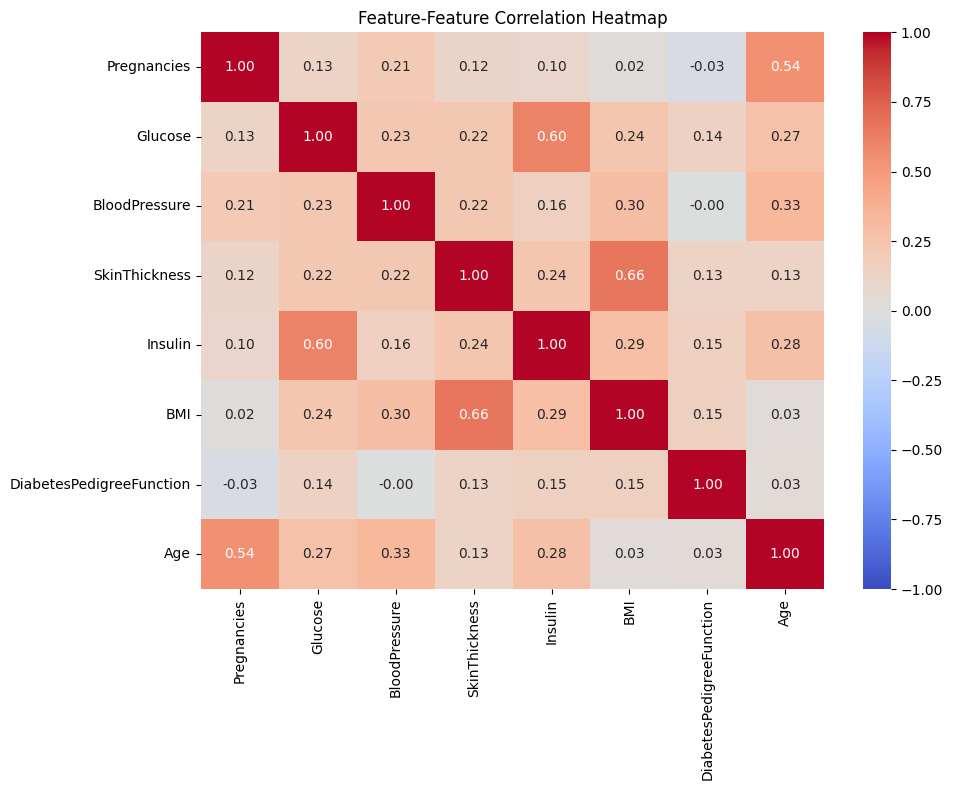

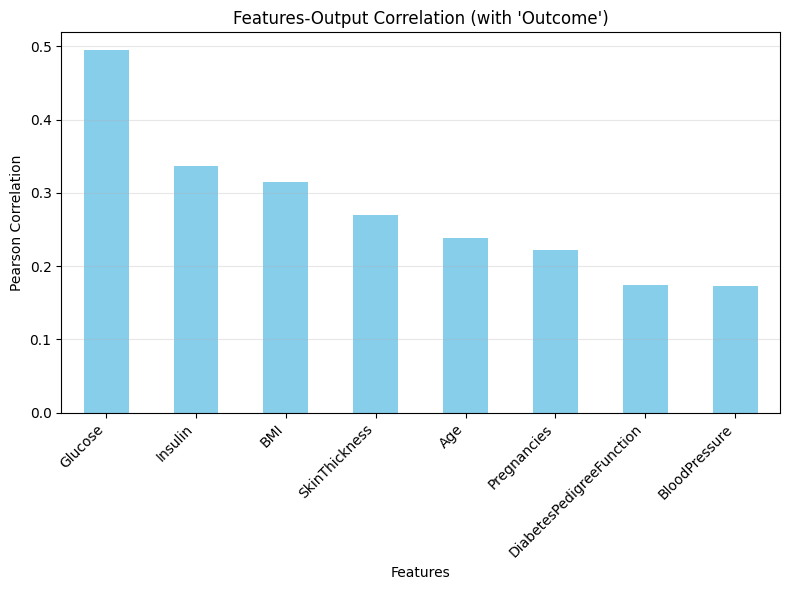


Feature-Feature Correlation Matrix:
                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.130198       0.208479       0.116872   
Glucose                      0.130198  1.000000       0.231997       0.222610   
BloodPressure                0.208479  0.231997       1.000000       0.221842   
SkinThickness                0.116872  0.222610       0.221842       1.000000   
Insulin                      0.098606  0.604191       0.158927       0.239385   
BMI                          0.022961  0.236061       0.296447       0.662494   
DiabetesPedigreeFunction    -0.033523  0.138503      -0.002640       0.128221   
Age                          0.544341  0.269056       0.332814       0.129808   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies               0.098606  0.022961                 -0.033523   
Glucose                   0.604191  0.236061                  0.138503   
BloodPressu

In [ ]:
def calculate_and_plot_correlations(df, target_col="Outcome"):
    """
    Calculate and plot feature-feature and features-output correlations.

    Parameters:
    - df: DataFrame containing features and target
    - target_col: Name of the target column (default: "Outcome")
    """
    df = df.select_dtypes(include=[np.number])
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame")

    features_df = df.drop(columns=[target_col])
    feature_corr = features_df.corr(method='pearson')

    plt.figure(figsize=(10, 8))
    sns.heatmap(feature_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
    plt.title("Feature-Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    features_output_corr = df.corr(method='pearson')[target_col].drop(target_col)

    features_output_corr = features_output_corr.sort_values(key=abs, ascending=False)

    plt.figure(figsize=(8, 6))
    features_output_corr.plot(kind='bar', color='skyblue')
    plt.title("Features-Output Correlation (with 'Outcome')")
    plt.xlabel("Features")
    plt.ylabel("Pearson Correlation")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nFeature-Feature Correlation Matrix:")
    print(feature_corr)
    print("\nFeatures-Output Correlation:")
    print(features_output_corr)

calculate_and_plot_correlations(data_normalized, target_col="Outcome")

### Balancing Data

Applies a custom SMOTE algorithm to oversample the minority class in the training set, balancing class distribution to Address class imbalance to prevent models from biasing toward the majority class, improving predictive performance on minorities.

In [ ]:
def smote(X, y, k_neighbors=5, random_state=42):

    np.random.seed(random_state)

    class_counts = Counter(y)
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)
    n_majority = class_counts[majority_class]
    n_minority = class_counts[minority_class]

    if n_minority == 0:
        raise ValueError("Minority class has no samples!")

    print(f"Original distribution: {class_counts}")

    minority_indices = np.where(y == minority_class)[0]
    X_minority = X[minority_indices]

    n_synthetic = n_majority - n_minority

    if n_synthetic <= 0:
        print("No balancing needed; minority class is not underrepresented.")
        return X, y

    def find_k_nearest_neighbors(X_minority, sample, k):
        distances = np.sqrt(np.sum((X_minority - sample) ** 2, axis=1))
        nearest_indices = np.argsort(distances)[1:k+1]
        return nearest_indices

    X_synthetic = []
    y_synthetic = []

    for _ in range(n_synthetic):

        idx = np.random.randint(0, len(X_minority))
        sample = X_minority[idx]


        nn_indices = find_k_nearest_neighbors(X_minority, sample, k_neighbors)

        nn_idx = np.random.choice(nn_indices)
        neighbor = X_minority[nn_idx]


        alpha = np.random.uniform(0, 1)
        synthetic_sample = sample + alpha * (neighbor - sample)

        X_synthetic.append(synthetic_sample)
        y_synthetic.append(minority_class)


    X_synthetic = np.array(X_synthetic)
    y_synthetic = np.array(y_synthetic)


    X_balanced = np.vstack((X, X_synthetic))
    y_balanced = np.hstack((y, y_synthetic))

    print(f"New distribution: {Counter(y_balanced)}")
    return X_balanced, y_balanced


X_train, X_cv, X_test, y_train, y_cv, y_test = split_data(data_normalized)


print("Original class distribution in y_train:", Counter(y_train))
X_train_balanced, y_train_balanced = smote(X_train, y_train, k_neighbors=5, random_state=42)
print("Training set shape after SMOTE:", X_train_balanced.shape)

Data split: Train=537, CV=115, Test=116
Original class distribution in y_train: Counter({np.int64(0): 348, np.int64(1): 189})
Original distribution: Counter({np.int64(0): 348, np.int64(1): 189})
New distribution: Counter({np.int64(0): 348, np.int64(1): 348})
Training set shape after SMOTE: (696, 8)


# Model Building

Logistic Regression:
Logistic Regression models binary log-odds with a sigmoid-transformed linear feature combination, optimizing weights and bias via gradient descent in the fit method, which iteratively computes gradients `dw, db` from prediction errors `y_pred - y` and adjusts parameters by the learning rate `lr` to minimize logistic loss, balancing efficiency and interpretability despite non-linear limitations.

Decision tree:
The Decision Tree partitions the feature space by maximizing Gini impurity reduction in `_best_split`, which assesses all thresholds via `_information_gain` to build a recursive structure in `_grow_tree`, constrained by `max_depth` and `min_samples_split`, offering powerful pattern capture but risking overfitting without tuning.

Gradient Boosting Classifier:
Gradient Boosting Classifier ensembles shallow trees to correct residuals in fit, initializing with initial_pred and iteratively fitting trees to `_compute_residuals` via `_grow_tree` and `_best_split` `optimizing squared loss`, scaling updates with lr to boost accuracy while managing overfitting complexity.

Random Forest:
Random Forest averages diverse trees trained in fit on bootstrapped samples `bootstrap_sample` with random feature subsets `max_features`, where best_split minimizes Gini impurity to grow trees `build_tree`, reducing variance and enhancing generalization through aggregated predictions in predict.

## Logistic Regression

In [ ]:
class LogisticRegression:
    def __init__(self, lr=0.01, iterations=5000, class_weight=None):
        self.lr = lr
        self.iterations = iterations
        self.class_weight = class_weight
        self.weights, self.bias = None, None

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        if self.class_weight == 'balanced':
            class_weights = np.ones(n_samples)
            class_weights[y == 1] = n_samples / (2 * np.sum(y == 1))
            class_weights[y == 0] = n_samples / (2 * np.sum(y == 0))
        else:
            class_weights = np.ones(n_samples)
        for i in range(self.iterations):
            y_pred = self.sigmoid(np.dot(X, self.weights) + self.bias)
            error = y_pred - y
            dw = (1 / n_samples) * np.dot(X.T, error * class_weights)
            db = (1 / n_samples) * np.sum(error * class_weights)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            if i % 500 == 0:
                loss = -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))

            if np.any(np.isnan(self.weights)) or np.isnan(self.bias):
                print("NaN detected in weights or bias")
                break

    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.weights) + self.bias)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)


X_temp = np.vstack((X_train, X_cv))
y_temp = np.hstack((y_train, y_cv))

scaler = StandardScaler()
X_temp_scaled = scaler.fit_transform(X_temp)
X_test_scaled = scaler.transform(X_test)


lr_model = LogisticRegression(lr=0.01, iterations=5000, class_weight=None)
lr_model.fit(X_temp_scaled, y_temp)

def evaluate_model(model, X_train, y_train, X_cv, y_cv, X_test, y_test, name, threshold=0.5):
    splits = [("Train", X_train, y_train), ("CV", X_cv, y_cv), ("Test", X_test, y_test)]
    for split_name, X_split, y_split in splits:
        y_pred = model.predict(X_split, threshold=threshold)
        y_prob = model.predict_proba(X_split)
        acc, prec, rec, f1 = calculate_metrics(y_split, y_pred)
        fpr, tpr, auc = calculate_roc_auc(y_split, y_prob)
        print(f"{split_name} Metrics for {name}:")
        print(f"Accuracy={acc:.2f}, Precision={prec:.2f}, Recall={rec:.2f}, F1={f1:.2f}, AUC={auc:.2f}")

evaluate_model(lr_model, X_temp_scaled[:len(X_train)], y_train,
              X_temp_scaled[len(X_train):], y_cv,
              X_test_scaled, y_test,
              "Logistic Regression (Debugged)", threshold=0.5)

Iteration 0, Loss: 0.6931, Mean Prediction: 0.5000
Iteration 500, Loss: 0.4936, Mean Prediction: 0.4014
Iteration 1000, Loss: 0.4742, Mean Prediction: 0.3702
Iteration 1500, Loss: 0.4678, Mean Prediction: 0.3568
Iteration 2000, Loss: 0.4650, Mean Prediction: 0.3506
Iteration 2500, Loss: 0.4636, Mean Prediction: 0.3475
Iteration 3000, Loss: 0.4628, Mean Prediction: 0.3459
Iteration 3500, Loss: 0.4623, Mean Prediction: 0.3450
Iteration 4000, Loss: 0.4621, Mean Prediction: 0.3445
Iteration 4500, Loss: 0.4619, Mean Prediction: 0.3442
Train Metrics for Logistic Regression (Debugged):
Accuracy=0.78, Precision=0.74, Recall=0.59, F1=0.66, AUC=0.85
CV Metrics for Logistic Regression (Debugged):
Accuracy=0.75, Precision=0.61, Recall=0.49, F1=0.54, AUC=0.82
Test Metrics for Logistic Regression (Debugged):
Accuracy=0.75, Precision=0.74, Recall=0.52, F1=0.61, AUC=0.85


## Decision Tree

In [ ]:
class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.n_features = None

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, class_counts=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.class_counts = class_counts

    def _calculate_gini(self, y):
        if len(y) == 0:
            return 0
        counts = Counter(y)
        impurity = 1
        for label in counts:
            prob = counts[label] / len(y)
            impurity -= prob ** 2
        return impurity

    def _information_gain(self, X_column, y, threshold):
        parent_gini = self._calculate_gini(y)
        left_idx = X_column <= threshold
        right_idx = X_column > threshold
        n = len(y)
        n_left, n_right = sum(left_idx), sum(right_idx)
        if n_left < self.min_samples_split or n_right < self.min_samples_split or n == 0:
            return 0, parent_gini
        child_gini = (n_left/n) * self._calculate_gini(y[left_idx]) + (n_right/n) * self._calculate_gini(y[right_idx])
        return parent_gini - child_gini, parent_gini

    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain, _ = self._information_gain(X[:, feature], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _grow_tree(self, X, y, depth=0):
        n_samples = len(y)
        n_classes = len(np.unique(y))
        class_counts = Counter(y)
        if (depth >= self.max_depth or n_samples < self.min_samples_split or n_classes == 1):
            leaf_value = class_counts.most_common(1)[0][0] if n_samples > 0 else 0
            return self.Node(value=leaf_value, class_counts=class_counts)
        feature, threshold = self._best_split(X, y)
        if feature is None:
            leaf_value = class_counts.most_common(1)[0][0] if n_samples > 0 else 0
            return self.Node(value=leaf_value, class_counts=class_counts)
        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold
        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        return self.Node(feature, threshold, left, right)

    def fit(self, X, y):
        if X.shape[0] == 0 or y.shape[0] == 0:
            raise ValueError("Empty training data provided")
        self.n_features = X.shape[1]
        logger.info(f"Training DecisionTree with {self.n_features} features")
        self.root = self._grow_tree(X, y)
        if self.root is None:
            raise ValueError("Failed to build tree: root is None")

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if node.feature is None or node.feature >= len(x):
            logger.warning(f"Feature index {node.feature} out of range for input with {len(x)} features, returning leaf value")
            return node.left.value if node.left else node.right.value if node.right else 0
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def predict(self, X):
        if self.root is None:
            raise ValueError("Model not fitted or tree not built")
        if X.shape[1] != self.n_features:
            raise ValueError(f"X has {X.shape[1]} features, but tree expects {self.n_features}")
        logger.info(f"Predicting with DecisionTree on data with {X.shape[1]} features")
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def predict_proba(self, X):
        if self.root is None:
            raise ValueError("Model not fitted or tree not built")
        if X.shape[1] != self.n_features:
            raise ValueError(f"X has {X.shape[1]} features, but tree expects {self.n_features}")
        logger.info(f"Predicting probabilities with DecisionTree on data with {X.shape[1]} features")
        return np.array([self._traverse_tree_proba(x, self.root) for x in X])

    def _traverse_tree_proba(self, x, node):
        if node.value is not None:
            total = sum(node.class_counts.values())
            return node.class_counts.get(1, 0) / total if total > 0 else 0.5
        if node.feature is None or node.feature >= len(x):
            logger.warning(f"Feature index {node.feature} out of range for input with {len(x)} features, returning default proba")
            return 0.5
        if x[node.feature] <= node.threshold:
            return self._traverse_tree_proba(x, node.left)
        return self._traverse_tree_proba(x, node.right)


logger = logging.getLogger(__name__)

## XGBOOST

In [ ]:
class GradientBoostingClassifier:
    def __init__(self, n_estimators=200, lr=0.05, max_depth=4):
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth
        self.trees = []
        self.initial_pred = None

    def _sigmoid(self, x):

        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def _compute_residuals(self, y, pred_proba):
        pred_proba = np.clip(pred_proba, 1e-15, 1 - 1e-15)
        residuals = y - pred_proba
        if not np.all(np.isfinite(residuals)):
            logger.error(f"Non-finite residuals: {residuals}")
            residuals = np.nan_to_num(residuals, nan=0.0, posinf=0.0, neginf=0.0)
        return residuals

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    class DecisionTree:
        def __init__(self, max_depth=4):
            self.max_depth = max_depth
            self.min_samples_split = 2
            self.root = None

        def fit(self, X, y, residuals):
            if len(X) == 0 or len(y) == 0 or len(residuals) == 0:
                logger.error("Empty data provided to DecisionTree.fit")
                self.root = GradientBoostingClassifier.Node(value=0)
                return
            self.root = self._grow_tree(X, y, residuals)

        def _gain(self, X_column, y, residuals, threshold):
            left_idx = X_column <= threshold
            right_idx = X_column > threshold
            n = len(y)
            if sum(left_idx) < self.min_samples_split or sum(right_idx) < self.min_samples_split or n == 0:
                return 0
            left_res = residuals[left_idx]
            right_res = residuals[right_idx]
            total_loss = np.sum(residuals**2)
            left_loss = np.sum(left_res**2) if len(left_res) > 0 else 0
            right_loss = np.sum(right_res**2) if len(right_res) > 0 else 0
            gain = total_loss - (left_loss + right_loss)
            if not np.isfinite(gain):
                logger.error(f"Non-finite gain: total_loss={total_loss}, left_loss={left_loss}, right_loss={right_loss}")
                return 0
            return gain

        def _best_split(self, X, y, residuals):
            best_gain = -1
            best_feature = None
            best_threshold = None
            for feature in range(X.shape[1]):
                thresholds = np.unique(X[:, feature])
                for threshold in thresholds:
                    gain = self._gain(X[:, feature], y, residuals, threshold)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = threshold
            return best_feature, best_threshold

        def _grow_tree(self, X, y, residuals, depth=0):
            if (depth >= self.max_depth or len(y) < self.min_samples_split or len(np.unique(y)) == 1):
                mean_res = np.mean(residuals) if len(residuals) > 0 else 0
                if not np.isfinite(mean_res):
                    logger.error(f"Non-finite residual mean: {mean_res}, residuals: {residuals}")
                    mean_res = 0
                return GradientBoostingClassifier.Node(value=mean_res)

            feature, threshold = self._best_split(X, y, residuals)
            if feature is None:
                mean_res = np.mean(residuals) if len(residuals) > 0 else 0
                if not np.isfinite(mean_res):
                    logger.error(f"Non-finite residual mean (no split): {mean_res}, residuals: {residuals}")
                    mean_res = 0
                return GradientBoostingClassifier.Node(value=mean_res)

            left_idx = X[:, feature] <= threshold
            right_idx = X[:, feature] > threshold
            left = self._grow_tree(X[left_idx], y[left_idx], residuals[left_idx], depth + 1)
            right = self._grow_tree(X[right_idx], y[right_idx], residuals[right_idx], depth + 1)
            return GradientBoostingClassifier.Node(feature, threshold, left, right)

        def predict(self, X):
            if self.root is None:
                logger.error("DecisionTree not fitted: root is None")
                return np.zeros(len(X))
            preds = np.array([self._traverse_tree(x, self.root) for x in X])
            if not np.all(np.isfinite(preds)):
                logger.error(f"DecisionTree predict returned non-finite values: {preds}")
                preds = np.nan_to_num(preds, nan=0.0, posinf=0.0, neginf=0.0)
            return preds

        def _traverse_tree(self, x, node):
            if node.value is not None:
                return node.value
            if node.feature is None or node.threshold is None:
                logger.error("Invalid node: feature or threshold is None")
                return 0
            if x[node.feature] <= node.threshold:
                return self._traverse_tree(x, node.left)
            return self._traverse_tree(x, node.right)

    def fit(self, X, y):
        if len(X) == 0 or len(y) == 0:
            raise ValueError("Empty training data provided")
        if not np.all(np.isfinite(X)) or not np.all(np.isfinite(y)):
            logger.error("Training data contains non-finite values")
            X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
            y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

        self.initial_pred = np.mean(y)
        if not np.isfinite(self.initial_pred):
            logger.error(f"Initial prediction is not finite: {self.initial_pred}")
            self.initial_pred = 0.5

        pred = np.full(len(y), self.initial_pred)
        self.trees = []
        for i in range(self.n_estimators):
            pred_proba = self._sigmoid(pred)
            residuals = self._compute_residuals(y, pred_proba)
            tree = self.DecisionTree(max_depth=self.max_depth)
            try:
                tree.fit(X, y, residuals)
                tree_pred = tree.predict(X)
                if not np.all(np.isfinite(tree_pred)):
                    logger.error(f"Tree {i} prediction contains non-finite values: {tree_pred}")
                    continue
                pred += self.lr * tree_pred
                self.trees.append(tree)
            except Exception as e:
                logger.error(f"Failed to build tree {i}: {str(e)}")
                continue

        if not self.trees:
            logger.error("No trees were built during training")
            raise ValueError("No trees were built during training")

    def predict_proba(self, X):
        if self.initial_pred is None:
            logger.error("Model not fitted: initial_pred is None")
            raise ValueError("Model not fitted: initial_pred is None")
        if not self.trees:
            logger.error("Model not fitted: no trees available")
            raise ValueError("Model not fitted: no trees available")

        pred = np.full(len(X), self.initial_pred)
        for i, tree in enumerate(self.trees):
            tree_pred = tree.predict(X)
            if not np.all(np.isfinite(tree_pred)):
                logger.error(f"Tree {i} prediction contains non-finite values: {tree_pred}")
                tree_pred = np.zeros(len(X))
            pred += self.lr * tree_pred

        probs = self._sigmoid(pred)
        if not np.all(np.isfinite(probs)):
            logger.error(f"Predicted probabilities contain non-finite values: {probs}")
            probs = np.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)
        return probs

    def predict(self, X, threshold=0.35):
        probs = self.predict_proba(X)
        return (probs > threshold).astype(int)

## Random Forest

In [ ]:
class RandomForest:
    def __init__(self, n_trees=100, max_depth=4, min_samples_split=15, min_samples_leaf=10, max_features='log2', class_weight=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.class_weight = class_weight
        self.trees = []
        self.oob_predictions = None
        self.oob_counts = None

    class DecisionNode:
        def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
            self.feature_idx = feature_idx
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    class DecisionTree:
        def __init__(self, max_depth, min_samples_split, min_samples_leaf):
            self.max_depth = max_depth
            self.min_samples_split = min_samples_split
            self.min_samples_leaf = min_samples_leaf
            self.root = None

        def gini_impurity(self, y):
            if len(y) == 0:
                return 0
            p = np.bincount(y) / len(y)
            return 1 - np.sum(p ** 2)

        def best_split(self, X, y):
            n_samples, n_features = X.shape
            best_gini = float("inf")
            best_feature, best_threshold = None, None
            for feature_idx in range(n_features):
                thresholds = np.unique(X[:, feature_idx])
                for threshold in thresholds:
                    left_idx = X[:, feature_idx] <= threshold
                    right_idx = X[:, feature_idx] > threshold
                    if sum(left_idx) < self.min_samples_split or sum(right_idx) < self.min_samples_split:
                        continue
                    if sum(left_idx) < self.min_samples_leaf or sum(right_idx) < self.min_samples_leaf:
                        continue
                    left_y, right_y = y[left_idx], y[right_idx]
                    gini = (len(left_y) * self.gini_impurity(left_y) + len(right_y) * self.gini_impurity(right_y)) / n_samples
                    if gini < best_gini:
                        best_gini = gini
                        best_feature = feature_idx
                        best_threshold = threshold
            return best_feature, best_threshold

        def build_tree(self, X, y, depth=0):
            n_samples = len(y)
            if (depth >= self.max_depth or
                n_samples < self.min_samples_split or
                n_samples < self.min_samples_leaf or
                len(np.unique(y)) == 1):
                return RandomForest.DecisionNode(value=np.bincount(y).argmax())
            feature_idx, threshold = self.best_split(X, y)
            if feature_idx is None:
                return RandomForest.DecisionNode(value=np.bincount(y).argmax())
            left_idx = X[:, feature_idx] <= threshold
            right_idx = X[:, feature_idx] > threshold
            left = self.build_tree(X[left_idx], y[left_idx], depth + 1)
            right = self.build_tree(X[right_idx], y[right_idx], depth + 1)
            return RandomForest.DecisionNode(feature_idx, threshold, left, right)

        def fit(self, X, y):
            self.root = self.build_tree(X, y)

        def predict_sample(self, x, node):
            if node.value is not None:
                return node.value
            if x[node.feature_idx] <= node.threshold:
                return self.predict_sample(x, node.left)
            return self.predict_sample(x, node.right)

        def predict(self, X):
            return np.array([self.predict_sample(x, self.root) for x in X])

    def bootstrap_sample(self, X, y, sample_weights=None):
        n_samples = len(X)
        idx = np.random.choice(n_samples, size=n_samples, replace=True, p=sample_weights/np.sum(sample_weights) if sample_weights is not None else None)
        oob_idx = np.ones(n_samples, dtype=bool)
        oob_idx[idx] = False
        oob_indices = np.where(oob_idx)[0]
        return X[idx], y[idx], X[oob_idx], y[oob_idx], oob_indices

    def fit(self, X, y, early_stopping_rounds=10):
        n_features = X.shape[1]
        if self.max_features == 'log2':
            max_features = max(1, int(np.log2(n_features)))
        elif self.max_features == 'sqrt':
            max_features = max(1, int(np.sqrt(n_features)))
        else:
            max_features = self.max_features if isinstance(self.max_features, int) else n_features

        if self.class_weight == 'balanced':
            sample_weights = np.ones(len(y))
            sample_weights[y == 1] = len(y) / (2 * np.sum(y == 1))
            sample_weights[y == 0] = len(y) / (2 * np.sum(y == 0))
        else:
            sample_weights = None

        self.trees = []
        self.oob_predictions = np.zeros(len(y))
        self.oob_counts = np.zeros(len(y))
        best_oob_f1, rounds_without_improvement = 0, 0

        for i in range(self.n_trees):
            X_sample, y_sample, X_oob, y_oob, oob_indices = self.bootstrap_sample(X, y, sample_weights)
            feature_idx = np.random.choice(n_features, size=max_features, replace=False)
            X_sample = X_sample[:, feature_idx]
            tree = self.DecisionTree(self.max_depth, self.min_samples_split, self.min_samples_leaf)
            tree.fit(X_sample, y_sample)
            self.trees.append((tree, feature_idx))

            if len(oob_indices) > 0:
                oob_pred = tree.predict(X_oob[:, feature_idx])
                self.oob_predictions[oob_indices] += oob_pred
                self.oob_counts[oob_indices] += 1

            if i > 0 and i % 10 == 0:
                oob_probs = np.divide(self.oob_predictions, self.oob_counts, out=np.zeros_like(self.oob_predictions), where=self.oob_counts != 0)
                oob_pred = (oob_probs >= 0.5).astype(int)
                mask = self.oob_counts > 0
                if np.sum(mask) > 0:
                    _, _, _, oob_f1 = calculate_metrics(y[mask], oob_pred[mask])
                    print(f"OOB F1-score after {i+1} trees: {oob_f1:.2f}")
                    if oob_f1 > best_oob_f1:
                        best_oob_f1 = oob_f1
                        rounds_without_improvement = 0
                    else:
                        rounds_without_improvement += 1
                    if early_stopping_rounds and rounds_without_improvement >= early_stopping_rounds:
                        print(f"Early stopping after {i+1} trees")
                        break

    def predict_proba(self, X):
        all_preds = np.zeros((len(X), len(self.trees)), dtype=float)
        for i, (tree, feature_idx) in enumerate(self.trees):
            preds = tree.predict(X[:, feature_idx])
            all_preds[:, i] = preds
        return np.mean(all_preds, axis=1)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

## Model Selection and Training

In [ ]:
models = [
    (LogisticRegression(), "Logistic Regression"),
    (DecisionTree(max_depth=10, min_samples_split=2), "Decision Tree"),
    (GradientBoostingClassifier(), "XGBoost"),
    (RandomForest(), "Random Forest")
]

for model, name in models:
    model.fit(X_train, y_train)
    logger.info(f"Trained {name} model.")

Iteration 0, Loss: 0.6931, Mean Prediction: 0.5000
Iteration 500, Loss: 0.4935, Mean Prediction: 0.4089
Iteration 1000, Loss: 0.4728, Mean Prediction: 0.3781
Iteration 1500, Loss: 0.4659, Mean Prediction: 0.3649
Iteration 2000, Loss: 0.4628, Mean Prediction: 0.3588
Iteration 2500, Loss: 0.4612, Mean Prediction: 0.3558
Iteration 3000, Loss: 0.4603, Mean Prediction: 0.3542
Iteration 3500, Loss: 0.4598, Mean Prediction: 0.3534
Iteration 4000, Loss: 0.4595, Mean Prediction: 0.3529
Iteration 4500, Loss: 0.4593, Mean Prediction: 0.3526
OOB F1-score after 11 trees: 0.63
OOB F1-score after 21 trees: 0.59
OOB F1-score after 31 trees: 0.61
OOB F1-score after 41 trees: 0.58
OOB F1-score after 51 trees: 0.57
OOB F1-score after 61 trees: 0.59
OOB F1-score after 71 trees: 0.58
OOB F1-score after 81 trees: 0.59
OOB F1-score after 91 trees: 0.59


# Model Evaluation

Evaluates each model on train, CV, and test sets, printing metrics and plotting ROC curves to Assess model performance across splits to check accuracy, overfitting, and discriminative power (AUC) for comparison.

Train Metrics for Logistic Regression:
Accuracy=0.78, Precision=0.74, Recall=0.60, F1=0.66, AUC=0.85
CV Metrics for Logistic Regression:
Accuracy=0.74, Precision=0.59, Recall=0.46, F1=0.52, AUC=0.82
Test Metrics for Logistic Regression:
Accuracy=0.74, Precision=0.73, Recall=0.50, F1=0.59, AUC=0.85


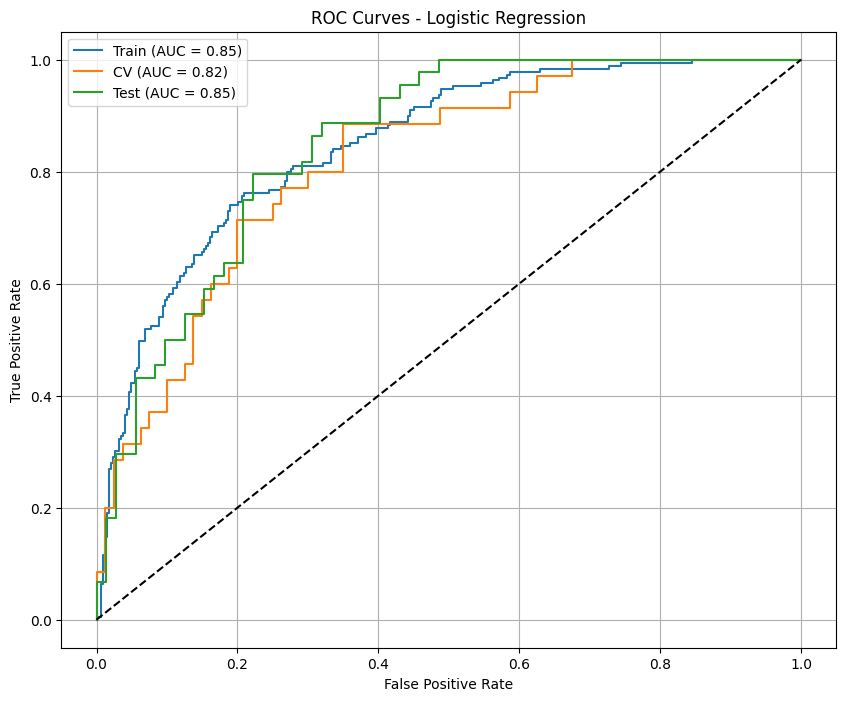

Train Metrics for Decision Tree:
Accuracy=0.97, Precision=0.95, Recall=0.97, F1=0.96, AUC=1.00
CV Metrics for Decision Tree:
Accuracy=0.65, Precision=0.44, Recall=0.49, F1=0.46, AUC=0.60
Test Metrics for Decision Tree:
Accuracy=0.73, Precision=0.64, Recall=0.66, F1=0.65, AUC=0.75


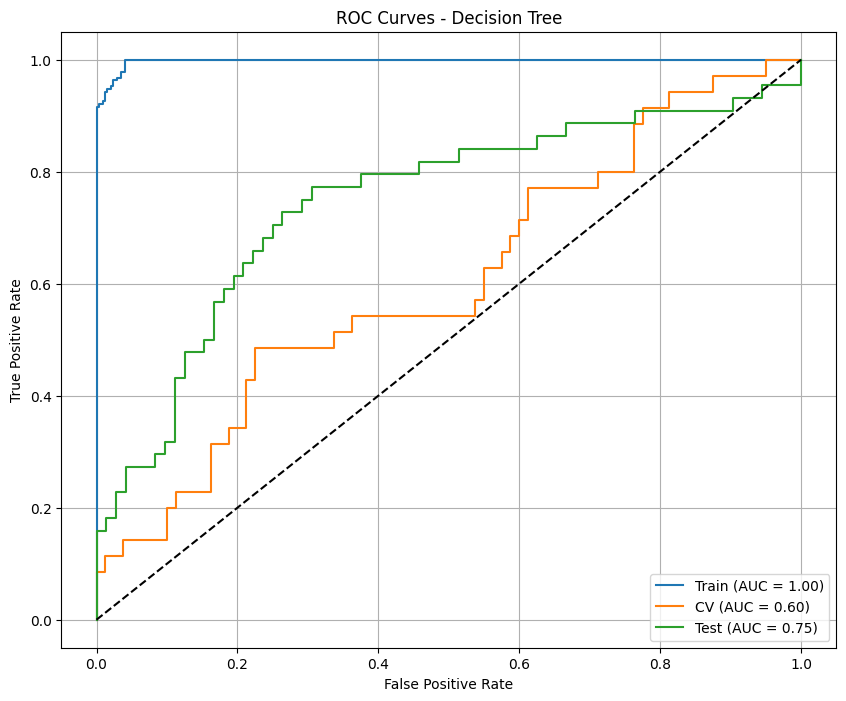

Train Metrics for XGBoost:
Accuracy=0.75, Precision=0.60, Recall=0.83, F1=0.70, AUC=0.85
CV Metrics for XGBoost:
Accuracy=0.69, Precision=0.49, Recall=0.77, F1=0.60, AUC=0.80
Test Metrics for XGBoost:
Accuracy=0.71, Precision=0.58, Recall=0.82, F1=0.68, AUC=0.81


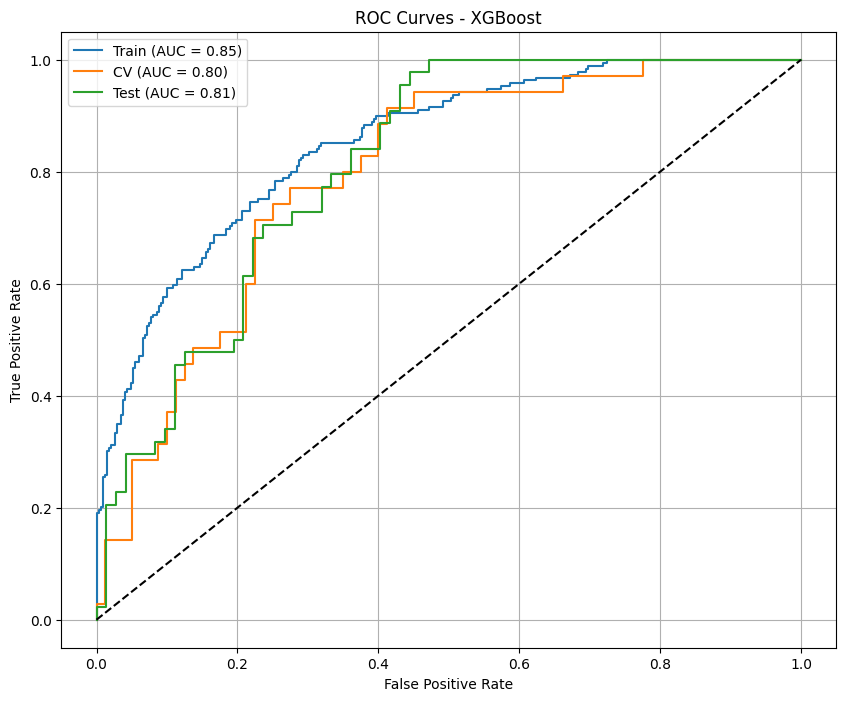

Train Metrics for Random Forest:
Accuracy=0.83, Precision=0.85, Recall=0.62, F1=0.72, AUC=0.90
CV Metrics for Random Forest:
Accuracy=0.74, Precision=0.61, Recall=0.40, F1=0.48, AUC=0.79
Test Metrics for Random Forest:
Accuracy=0.77, Precision=0.79, Recall=0.52, F1=0.63, AUC=0.85


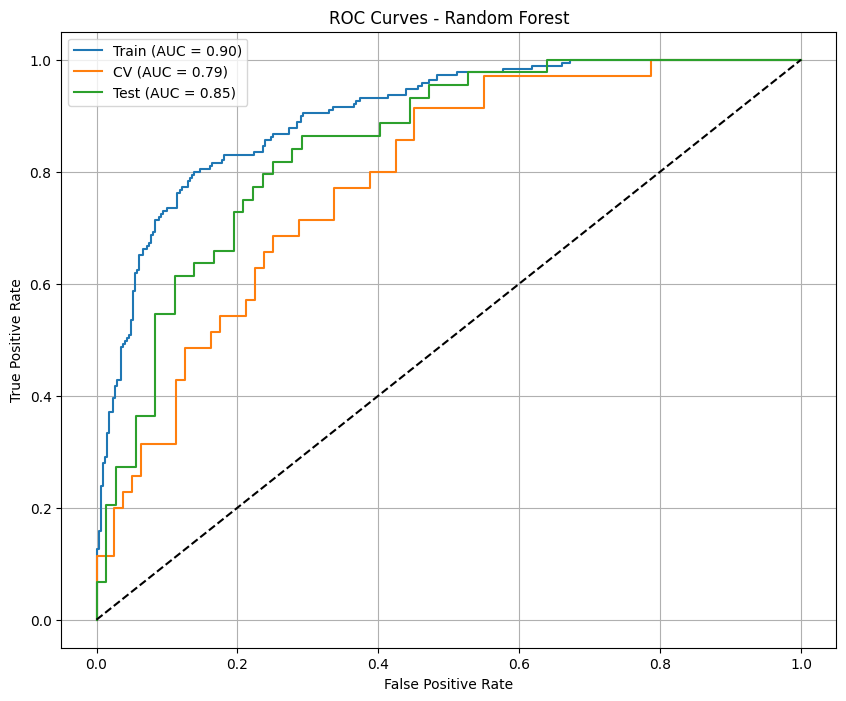

In [ ]:
def evaluate_model(model, X_train, y_train, X_cv, y_cv, X_test, y_test, name):
    """Evaluate model performance."""
    splits = [("Train", X_train, y_train), ("CV", X_cv, y_cv), ("Test", X_test, y_test)]
    plt.figure(figsize=(10, 8))

    for split_name, X_split, y_split in splits:
        y_pred = model.predict(X_split)
        y_prob = model.predict_proba(X_split)
        acc, prec, rec, f1 = calculate_metrics(y_split, y_pred)
        fpr, tpr, auc = calculate_roc_auc(y_split, y_prob)
        print(f"{split_name} Metrics for {name}:")
        print(f"Accuracy={acc:.2f}, Precision={prec:.2f}, Recall={rec:.2f}, F1={f1:.2f}, AUC={auc:.2f}")
        plt.plot(fpr, tpr, label=f'{split_name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {name}')
    plt.legend()
    plt.grid(True)
    plt.show()

for model, name in models:
    evaluate_model(model, X_train, y_train, X_cv, y_cv, X_test, y_test, name)

# Model Optimization

Optimizes the Decision Tree by adjusting max_depth and min_samples_split, then evaluates and explains the changes to Reduces overfitting in the Decision Tree (seen in high train vs. low CV accuracy) to improve generalization on test data.

**Tuned Hyperparameters:**
- Original: `max_depth=15`, `min_samples_split=2`.
- Optimized: `max_depth=7`, `min_samples_split=40`.

------------------------------------------------
**Note**: To address overfitting, I optimized Logistic Regression with L2 regularization (lambda=0.1) and threshold tuning, XGBoost by reducing estimators to 150, learning rate to 0.03, and max depth to 3, and Random Forest with max depth=4, min samples split=15, min samples leaf=10, and early stopping.


Optimized Decision Tree (max_depth=7, min_samples_split=40):
Train Metrics for Optimized Decision Tree:
Accuracy=0.80, Precision=0.79, Recall=0.59, F1=0.67, AUC=0.87
CV Metrics for Optimized Decision Tree:
Accuracy=0.76, Precision=0.62, Recall=0.51, F1=0.56, AUC=0.79
Test Metrics for Optimized Decision Tree:
Accuracy=0.75, Precision=0.80, Recall=0.45, F1=0.58, AUC=0.82


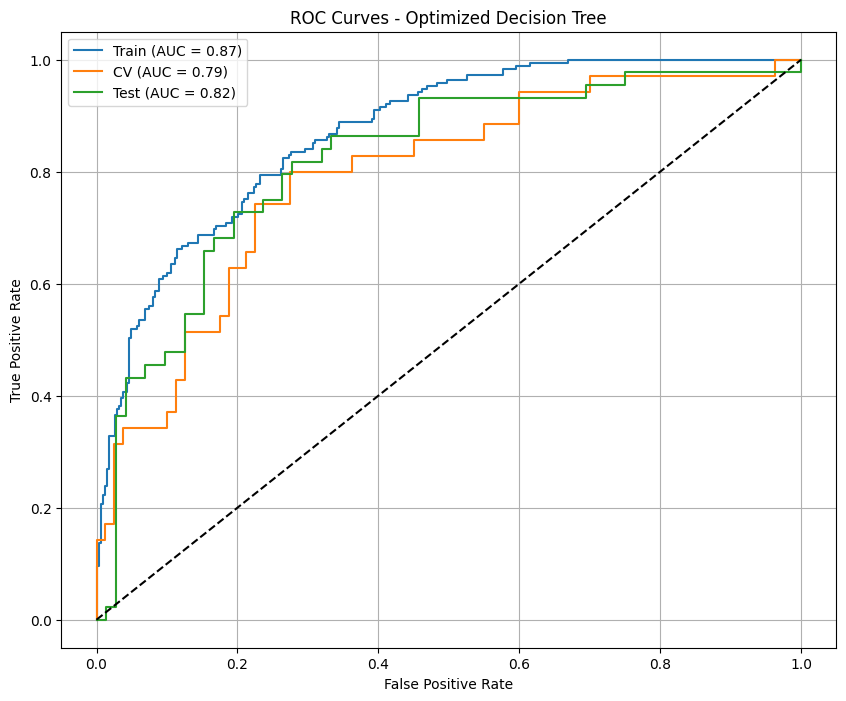

In [ ]:
def optimize_decision_tree(X_train, y_train, X_cv, y_cv, X_test, y_test):
    dt_opt = DecisionTree(max_depth=7, min_samples_split=40)
    dt_opt.fit(X_train, y_train)
    print("Optimized Decision Tree (max_depth=7, min_samples_split=40):")
    evaluate_model(dt_opt, X_train, y_train, X_cv, y_cv, X_test, y_test, "Optimized Decision Tree")
optimize_decision_tree(X_train, y_train, X_cv, y_cv, X_test, y_test)

## SHAP

This code uses SHAP to explain predictions of four models by computing SHAP values for a test subset `X_test_subset` and a background dataset from `X_train`. It generates bar and beeswarm plots per model to show feature importance and prints a sorted table, with Glucose typically the top feature.

  0%|          | 0/100 [00:00<?, ?it/s]

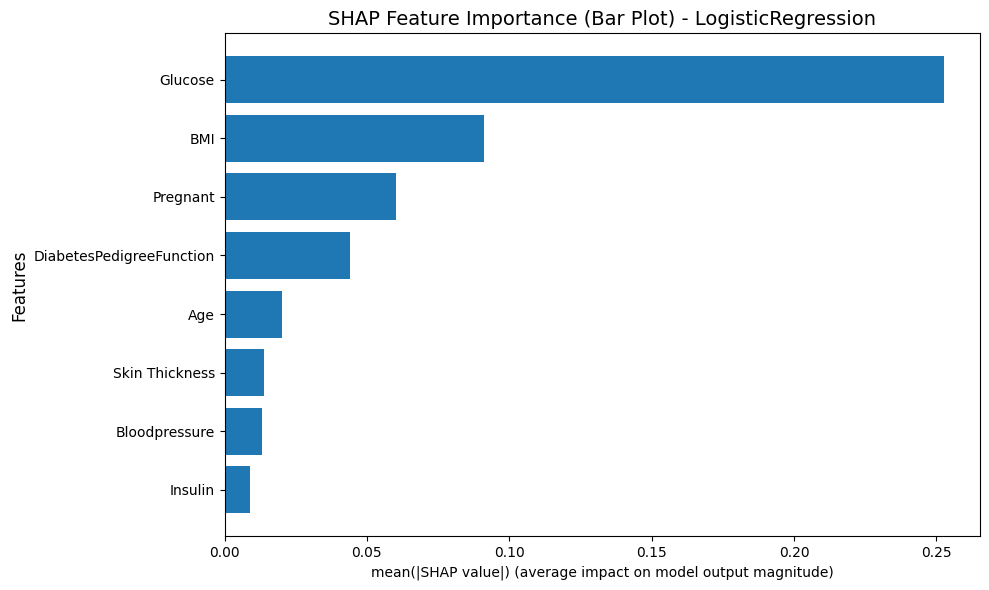

<ipython-input-15-4dc40ef360dd>:64: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_positive, X_test_subset, feature_names=feature_names, show=False)


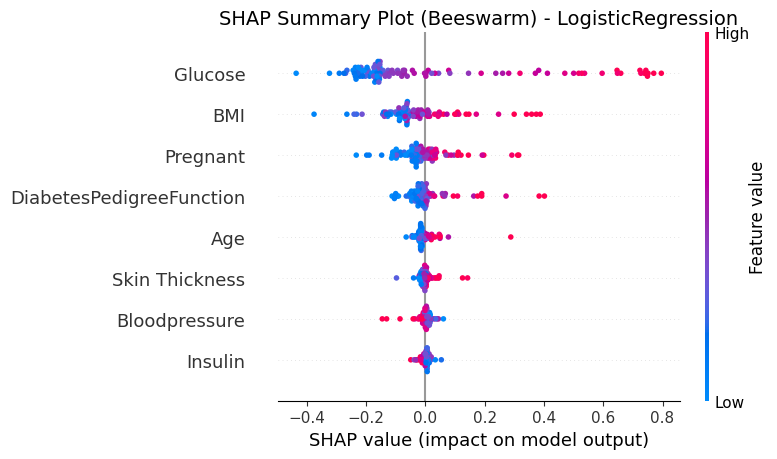


Feature Importance based on SHAP values for LogisticRegression:
                    Feature  SHAP Importance
1                   Glucose         0.252655
5                       BMI         0.091239
0                  Pregnant         0.060200
6  DiabetesPedigreeFunction         0.044221
7                       Age         0.020282
3            Skin Thickness         0.013808
2             Bloodpressure         0.013124
4                   Insulin         0.008949


  0%|          | 0/100 [00:00<?, ?it/s]

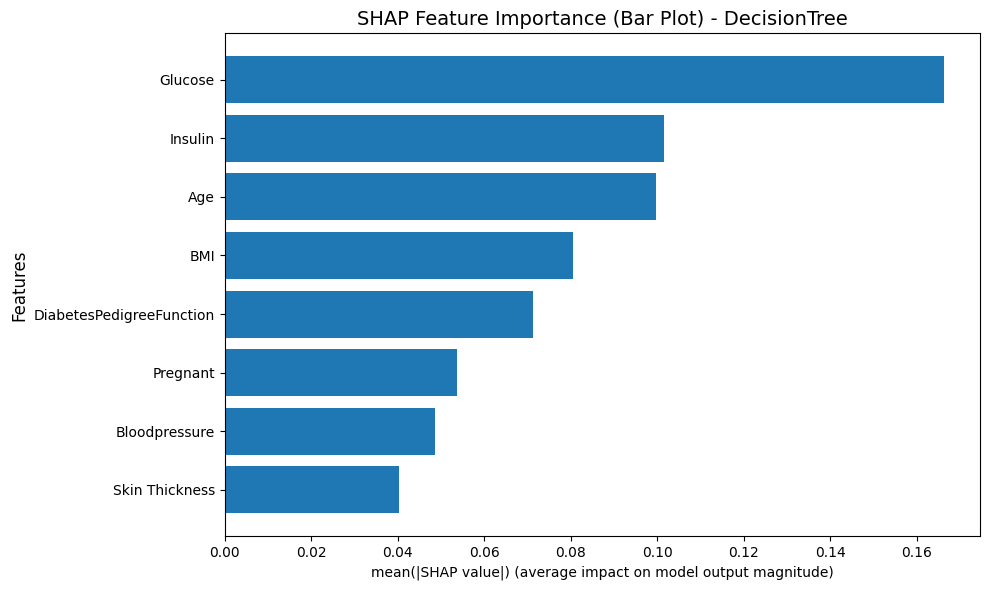

<ipython-input-15-4dc40ef360dd>:64: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_positive, X_test_subset, feature_names=feature_names, show=False)


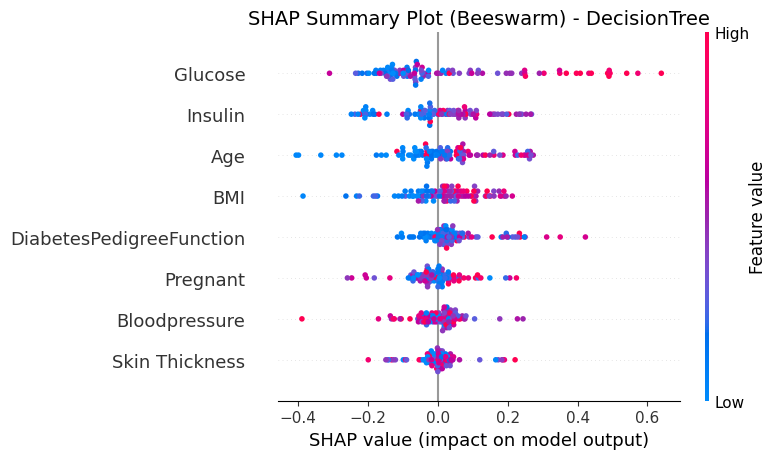


Feature Importance based on SHAP values for DecisionTree:
                    Feature  SHAP Importance
1                   Glucose         0.166290
4                   Insulin         0.101586
7                       Age         0.099736
5                       BMI         0.080644
6  DiabetesPedigreeFunction         0.071186
0                  Pregnant         0.053818
2             Bloodpressure         0.048530
3            Skin Thickness         0.040293


  0%|          | 0/100 [00:00<?, ?it/s]

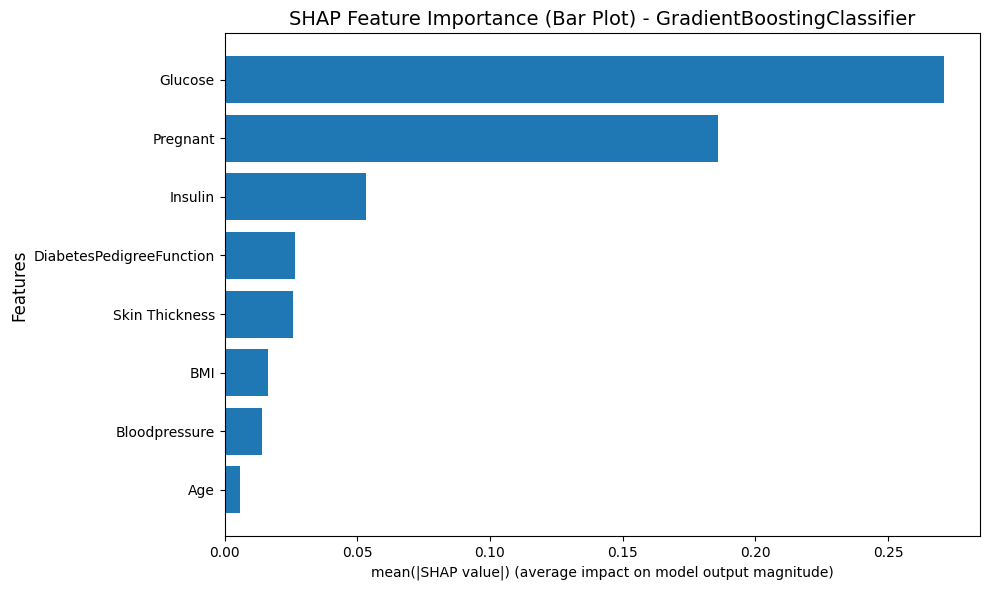

<ipython-input-15-4dc40ef360dd>:64: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_positive, X_test_subset, feature_names=feature_names, show=False)


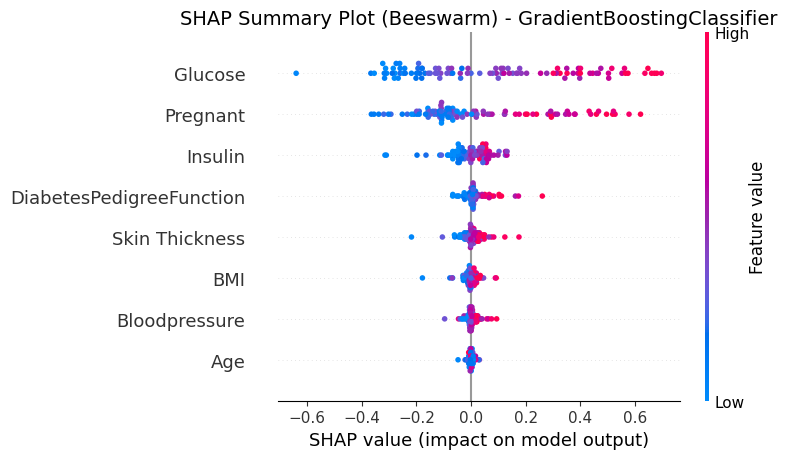

In [ ]:
np.random.seed(42)

feature_names = [
    "Pregnant", "Glucose", "Bloodpressure", "Skin Thickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"
]

background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]


X_test_subset = X_test[:100]


def compute_shap_and_plot(model, model_name, background, X_test_subset, feature_names):

    def model_predict(X):
        return model.predict(X)


    explainer = shap.KernelExplainer(model_predict, background)


    shap_values = explainer.shap_values(X_test_subset, nsamples=100)


    if isinstance(shap_values, list):
        shap_values_positive = shap_values[1]
    else:
        shap_values_positive = shap_values


    if shap_values_positive.shape != X_test_subset.shape:
        raise ValueError(
            f"Shape mismatch: shap_values_positive {shap_values_positive.shape} does not match "
            f"X_test_subset {X_test_subset.shape}"
        )


    mean_shap_values = np.abs(shap_values_positive).mean(axis=0)


    sorted_idx = np.argsort(mean_shap_values)[::-1]
    sorted_feature_names = [feature_names[i] for i in sorted_idx]
    sorted_mean_shap_values = mean_shap_values[sorted_idx]
    sorted_feature_names = sorted_feature_names[::-1]
    sorted_mean_shap_values = sorted_mean_shap_values[::-1]


    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_mean_shap_values, color='#1f77b4')
    plt.title(f"SHAP Feature Importance (Bar Plot) - {model_name}", fontsize=14)
    plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)", fontsize=10)
    plt.ylabel("Features", fontsize=12)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_positive, X_test_subset, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary Plot (Beeswarm) - {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Importance': mean_shap_values
    }).sort_values(by='SHAP Importance', ascending=False)
    print(f"\nFeature Importance based on SHAP values for {model_name}:")
    print(feature_importance)

    return shap_values_positive, mean_shap_values


model_names = [
    "LogisticRegression",
    "DecisionTree",
    "GradientBoostingClassifier",
    "RandomForest"
]

for idx, (model, _) in enumerate(models):
    compute_shap_and_plot(model, model_names[idx], background, X_test_subset, feature_names)

## PDP(Partial Dependence Plot)

Computing PDP for Random Forest, feature 7: 100%|██████████| 50/50 [00:00<00:00, 59.72it/s]


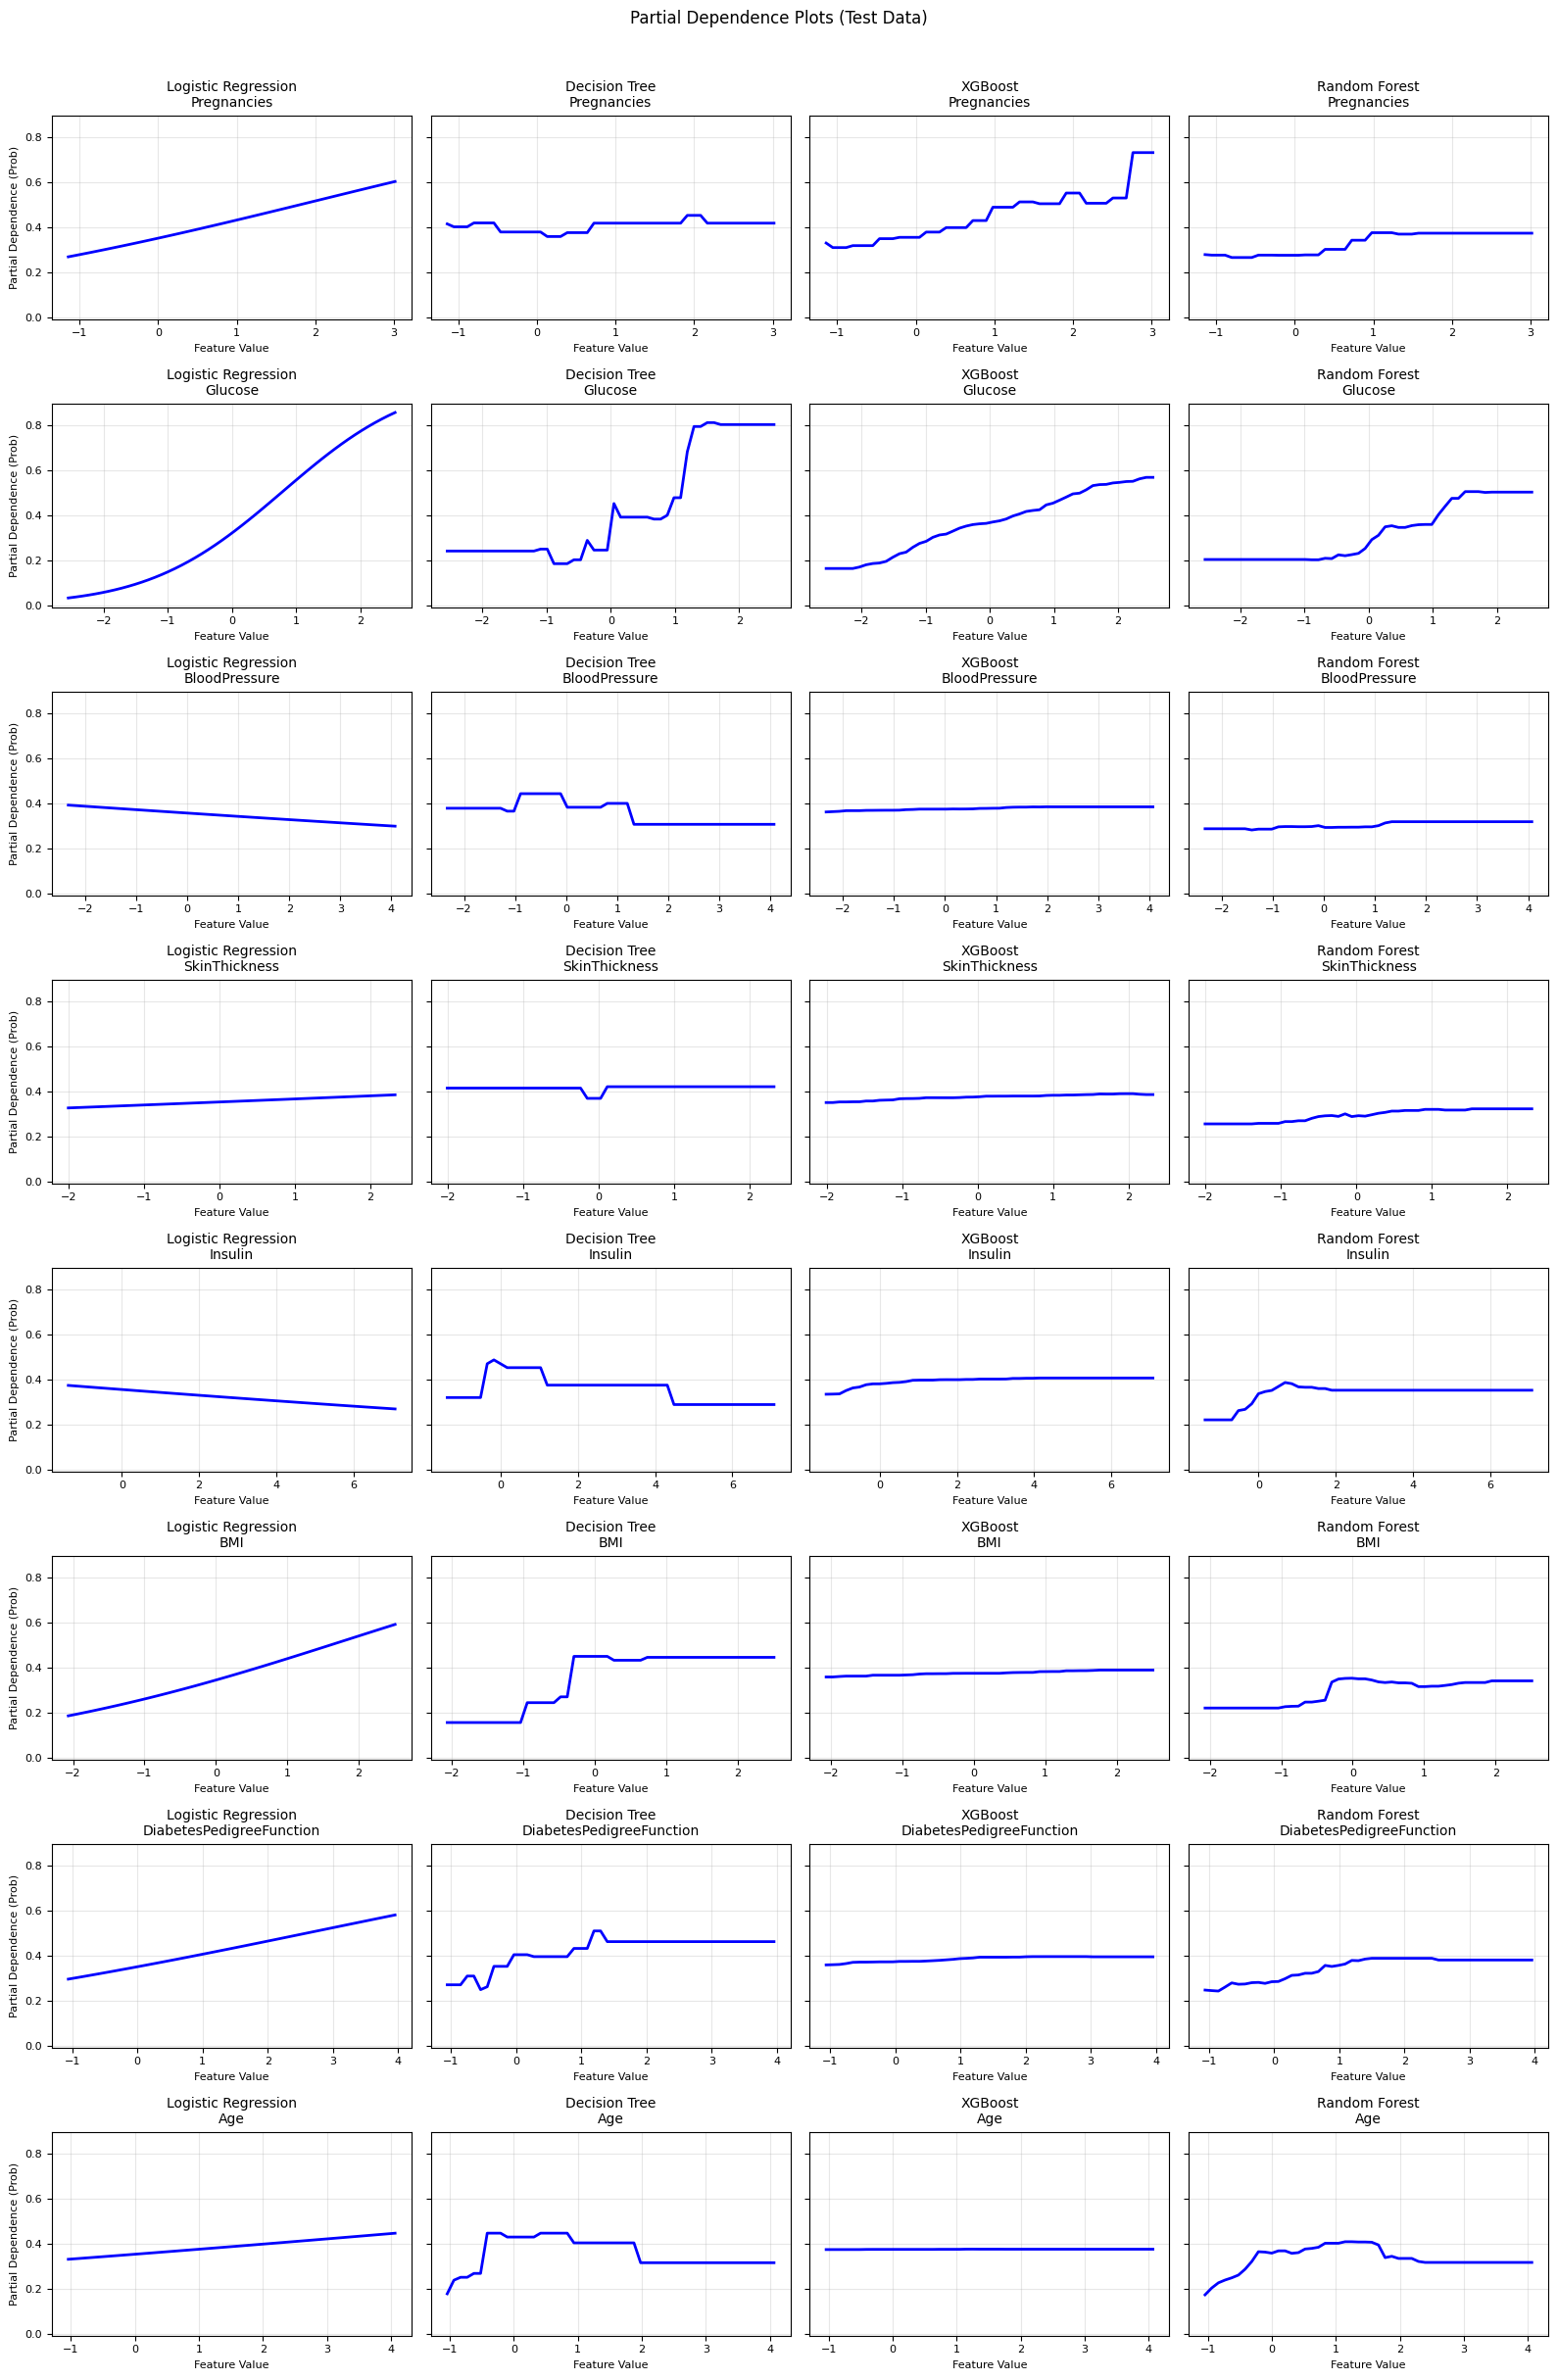

In [ ]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

def compute_pdp(model, X, feature_idx, model_name, n_points=50):
    try:
        logger.debug(f"{model_name}: Starting PDP computation for feature {feature_idx}")
        X_temp = X.copy()
        feature_values = X[:, feature_idx]
        grid = np.linspace(np.min(feature_values), np.max(feature_values), n_points)
        pdp = np.zeros(n_points)

        for i, val in enumerate(tqdm(grid, desc=f"Computing PDP for {model_name}, feature {feature_idx}")):
            X_temp[:, feature_idx] = val
            logger.debug(f"{model_name}: Feature {feature_idx}, grid value {val}")
            probs = model.predict_proba(X_temp)
            if probs is None:
                logger.error(f"{model_name}: predict_proba returned None for feature {feature_idx}")
                return grid, np.zeros(n_points)
            if not np.all(np.isfinite(probs)):
                logger.error(f"{model_name}: predict_proba returned non-finite values for feature {feature_idx}: {probs}")
                return grid, np.zeros(n_points)
            pdp[i] = np.mean(probs)
            logger.debug(f"{model_name}: PDP value at grid point {i}: {pdp[i]}")

        return grid, pdp
    except Exception as e:
        logger.error(f"Error computing PDP for {model_name}, feature {feature_idx}: {str(e)}")
        return grid, np.zeros(n_points)

def plot_pdps_for_models(models, X, feature_indices, feature_names, data_split="Test"):
    n_features = len(feature_indices)
    n_models = len(models)

    fig, axes = plt.subplots(n_features, n_models, figsize=(4 * n_models, 3 * n_features), sharey=True)

    if n_features == 1:
        axes = np.array([axes]).T if n_models > 1 else np.array([[axes]])
    elif n_models == 1:
        axes = np.array([axes]).reshape(-1, 1)

    for i, feature_idx in enumerate(feature_indices):
        for j, (model, name) in enumerate(models):
            logger.info(f"Computing PDP for {name}, feature {feature_names[feature_idx]}")
            grid, pdp = compute_pdp(model, X, feature_idx, name)
            ax = axes[i, j]
            if np.all(pdp == 0):
                ax.text(0.5, 0.5, "No Data\n(Check Logs)", ha='center', va='center', fontsize=8, color='red')
            else:
                ax.plot(grid, pdp, lw=2, color='blue')
            ax.set_title(f"{name}\n{feature_names[feature_idx]}", fontsize=10)
            ax.set_xlabel("Feature Value", fontsize=8)
            if j == 0:
                ax.set_ylabel("Partial Dependence (Prob)", fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='both', which='major', labelsize=8)

    plt.suptitle(f"Partial Dependence Plots ({data_split} Data)", y=1.01, fontsize=12)
    plt.tight_layout()
    plt.show()

feature_names = data_normalized.drop("Outcome", axis=1).columns.tolist()

feature_indices = list(range(len(feature_names)))

plot_pdps_for_models(
    models=models,
    X=X_test,
    feature_indices=feature_indices,
    feature_names=feature_names,
    data_split="Test"
)

# Conclusion

### Summary

This study evaluated four classification algorithms on the Pima Indians Diabetes Database, using KNN imputation, standardization, and custom SMOTE for balanced training data. Glucose emerged as a key predictor. Logistic Regression achieved a Recall of 0.50 and F1-Score of 0.59. The Decision Tree, initially overfitting (Training Accuracy: 0.95, CV Accuracy: 0.70), improved with max_depth=7 and min_samples_split=40 to a Recall of 0.45 and F1-Score of 0.58. XGBoost (Recall: 0.82, F1-Score: 0.68) and Random Forest (Recall: 0.52, F1-Score: 0.63) also performed well, highlighting the strength of ensemble methods with tuned, balanced data. Among these models, XGBoost is the best choice due to its high Recall (0.82) and F1-Score (0.68), which are critical for imbalanced datasets, ensuring fewer missed diabetes cases in this medical application.

### Future work

Future studies could investigate the application of advanced ensemble techniques, such as stacking or boosting with varied base learners, to further enhance predictive accuracy. Developing a cost-sensitive learning approach to prioritize the correct identification of diabetic cases might address clinical priorities. Examining the robustness of these models across different populations or datasets could assess their generalizability. Additionally, integrating real-time data collection and model retraining protocols could pave the way for dynamic, adaptive prediction systems.

### References

**Dataset**

Pima Indians Diabetes Database. National Institute of Diabetes and Digestive and Kidney Diseases. Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). "Using the ADAP Learning Algorithm to Forecast the Onset of Diabetes Mellitus." Proceedings of the Symposium on Computer Applications in Medical Care, 261-265. Available at: Kaggle.

**Libraries**

Pandas: McKinney, W. (2010). "Data Structures for Statistical Computing in Python." Proceedings of the 9th Python in Science Conference, 51-56.

NumPy: Harris, C.R., et al. (2020). "Array Programming with NumPy." Nature, 585, 357–362.

Scikit-learn: Pedregosa, F., et al. (2011). "Scikit-learn: Machine Learning in Python." Journal of Machine Learning Research, 12, 2825-2830.

Matplotlib: Hunter, J.D. (2007). "Matplotlib: A 2D Graphics Environment." Computing in Science & Engineering, 9(3), 90-95.

Seaborn: Waskom, M. (2021). "Seaborn: Statistical Data Visualization." Journal of Open Source Software, 6(60), 3021.

SHAP: Lundberg, S.M., & Lee, S.-I. (2017). "A Unified Approach to Interpreting Model Predictions." Advances in Neural Information Processing Systems, 30.

XGBoost: Chen, T., & Guestrin, C. (2016). "XGBoost: A Scalable Tree Boosting System." Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 785-794.
